In [1]:
import sys 
import os 
from os import path

RESULTS_DIR = '../experiments/results'
GRAPHICS_DIR = '../experiments/results/graphics'

####
# Tenemos que hacer esto por como estan definidos los packages del tp tlengrep
# Si no se ejecuta desde telengrep rompe la ejecucion.
# Lo que hacemos es correr la notebook seteando el "working directory" de python
# como si corriera desde /tlengrep
###
def hack_path_enviroment():
    sys.path.insert(0, "..")
    #os.getcwd()
    os.chdir('../tlengrep/')
    #os.getcwd()


def init_folders():
    if path.exists(f'{RESULTS_DIR}') == False:
        os.mkdir(f'{RESULTS_DIR}')

    if path.exists(f'{GRAPHICS_DIR}') == False:
        os.mkdir(f'{GRAPHICS_DIR}')



In [3]:
hack_path_enviroment()
init_folders()

In [41]:
import tlengrep.regex as regex
l = regex.Lambda()
l.naive_match('a')

False

### Common implementation

In [5]:
import timeit as ti 


def time_regular_expression(reg_exp_dict, instances, verbose=1):

    results = {}
    results['instance'] = instances 
    time_results = []
    results[f'{reg_exp_dict["name"]} - avg time (ms)'] = time_results
    naive_time_results = []
    results[f'{reg_exp_dict["name"]} - naive - avg time (ms)'] = naive_time_results

    reg_exp = reg_exp_dict['regex']
    EXPERIMENT_RUNS = 100 
    if verbose >= 1:
        print(f'Timing regular expression for {len(instances)} instances with {EXPERIMENT_RUNS} experiment runs')

    for idx, instance in enumerate(instances):
        if verbose >= 2:
            print(f'Running experiment {idx} ...')
        
        ## Calculate regular expression time 
        times = ti.repeat(lambda: reg_exp.match(instance), number=1, repeat=EXPERIMENT_RUNS)
        #time = (time / EXPERIMENT_RUNS) * 1000
        time = min(times) * 1000
        time_results.append(time)

        if verbose >= 2:
            print(f'Regular expression average time {time}')

        ## Calculate naive regular expression time 
        times = ti.repeat(lambda: reg_exp.naive_match(instance), number=1, repeat=EXPERIMENT_RUNS)
        #time = (time / EXPERIMENT_RUNS) * 1000
        time = min(times) * 1000
        naive_time_results.append(time)

        if verbose >= 2:
            print(f'Regular expression naive implementation average time {time}')
    

    return results


import pandas as pd 
def execute_cached_metric(file_name, metric_execution, dataframe_builder=None):
  results = None
  df = None
  file_name = f'{RESULTS_DIR}/{file_name}'
  if path.exists(file_name) == False:
    ## Si no hay un .csv ejecutamos la metrica
    results = metric_execution()
    if dataframe_builder != None:
      ## Si se provee un "dataframe_builder" entonces lo usamos para
      ## construir el dataframe
      df = dataframe_builder(results)
    else:
      df = pd.DataFrame(results)
    df = dataframe_builder(results)
    df.to_csv(file_name)
  else:
    ## LOAD dataframe from csv file
    df = pd.read_csv(file_name)

  return df

def execute_cached_experiment(file_name, metric_execution):
  results_df = None
  file_name = f'{RESULTS_DIR}/{file_name}'
  if path.exists(file_name) == False:
    ## Si no hay un .csv ejecutamos la metrica
    results_df = metric_execution()
    results_df.to_csv(file_name)
  else:
    ## LOAD dataframe from csv file
    results_df = pd.read_csv(file_name)

  return results_df

### Experiments 1

#### Implementations

In [37]:
TOTAL_INSTANCES = 10
SIZE_STEP = 100
instances = ["ab" * (i*SIZE_STEP) for i in range(1, TOTAL_INSTANCES + 1)]

def generate_regular_expression_1():
    return regex.Star(regex.Concat(regex.Char('a'), regex.Char('b')))

reg_ex_dict = {
    're_1': {
        'name': 're_1',
        'regex': generate_regular_expression_1(),
        'regex_str': '(ab)*'}
}
    

In [38]:
def execute_experiment_1():
    results = time_regular_expression(reg_ex_dict['re_1'], instances, verbose=2)
    df = pd.DataFrame(results)
    df['instance size'] = df['instance'].apply(lambda x: len(x))
    df = df.drop(['instance'], axis=1)
    df = df.set_index('instance size')
    return df

#### Metrics

In [39]:
exp1_df = execute_cached_experiment('exp1.csv', execute_experiment_1)
exp1_df = exp1_df.set_index('instance size')
exp1_df

,re_1 - avg time (ms),re_1 - naive - avg time (ms)
instance size,,
200,0.181149,3.319291
400,0.223608,6.897426
600,0.148769,15.880334
800,0.165373,29.456193
1000,0.184007,45.706786
1200,0.210030,67.962056
1400,0.220329,92.510662
1600,0.237688,125.513178
1800,0.259325,160.304261


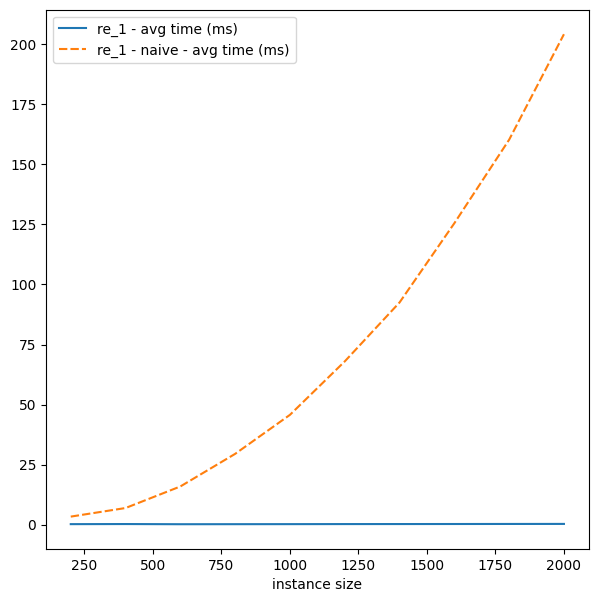

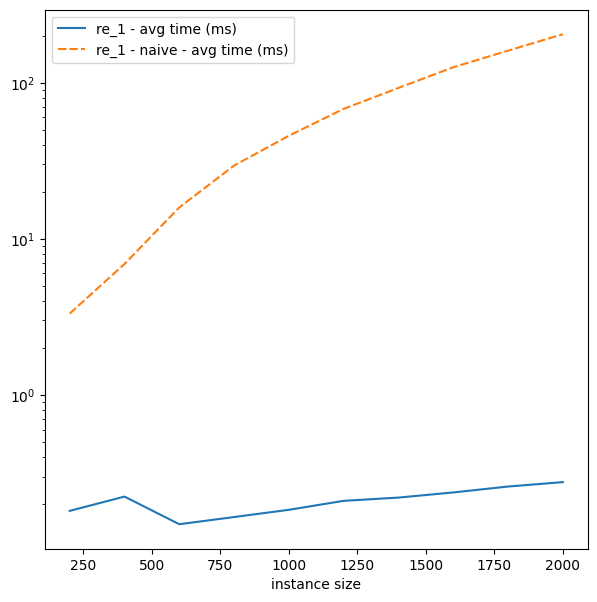

In [40]:
import seaborn as sns

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
sns.lineplot(data=exp1_df, ax=axes)
plt.savefig(f'{GRAPHICS_DIR}/exp1_re_1_times.png')

fig, axes = plt.subplots(1, 1, figsize=(7, 7))
sns.lineplot(data=exp1_df, ax=axes)
axes.set_yscale('log')
plt.savefig(f'{GRAPHICS_DIR}/exp1_re_1_log_times.png')



### Experiments 2

#### Implementations

In [21]:
import string 


# Genera una expresión regular donde una cadena de exto es recorrida k veces hasta el ultimo caracter
# Para esto seleccionamos k caracteres {c1,...ck} y obtenemos las clausuras de kleene {c1*, ..., ck*}.
# Realizamos la concatenación en una expresión regular R1 = c1*c2*...ck*
# Luego tomamos k caracteres distintos {d1,...dk} a los que no les realizamos la clasura y construimos la expresión.
# regular R = (R1 d1 | R1 d2 | R1 d3 | ... | R1 dk)
# para esto hacemos una "suma" de distintas clausuras de kleene para cada caracter 
# Ahora si construimos un string como "R1 dk" la expresión regular debera recorrer 
# cada caso fallando unicamente en el último caracter y
def generate_regulat_expression_2(size=3):
    assert(size*2 <= 52)
    all_letters = list(string.ascii_letters)
    #print(len(all_letters))
    result_alphabet = []

    ## Primero generamos a*, b*, ... hasta size
    closures = []
    for idx in range (0, size):
        letter = all_letters[idx]
        re = regex.Star(regex.Char(letter))
        closures.append(re)
        result_alphabet.append(letter)

    ## Nos con los siguientes k characteres
    sub_regexes = []
    for i in range(0, size):
        idx = (size+i)
        letter = all_letters[idx]
        re = regex.Concat(closures[i], regex.Char(letter))
        sub_regexes.append(re)
        result_alphabet.append(letter)

    ## Ahora generamos la suma de todos los sub_regexes para
    ## construir R = (R1 d1 | ... | R1 dk)
    final_regex = None
    for sub_re in sub_regexes:
        if final_regex is None:
            final_regex = sub_re

        else:
            final_regex = regex.Union(final_regex, sub_re)


    return result_alphabet, final_regex




generate_regulat_expression_2()

(['a', 'b', 'c', 'd', 'e', 'f'], <tlengrep.regex.Union at 0x7f5120dc4c40>)

In [22]:
import random 

EXP2_INSTANCE_SIZES = [5,10,15,20,25]

def generate_exp2_reg_exe_dict():
    exp2_reg_ex_dict = {}    
    for i in EXP2_INSTANCE_SIZES:
        re_dict = {}
        alph, re = generate_regulat_expression_2(size=i)
        re_dict['name'] = f'exp2_re_{i}'
        re_dict['alph'] = alph 
        re_dict['regex'] = re 
        exp2_reg_ex_dict[re_dict['name']] = re_dict

    return exp2_reg_ex_dict

def generate_exp2_instances(exp2_reg_ex_dict):
    exp2_instances_dict = {}

    def generate_instances_for_re_2(alphabet, total_instances=10, size_step=100):
        usable_alph = alphabet.copy()
        last_character = usable_alph.pop()
        instances = [  ''.join(random.choices(usable_alph, k=(i*size_step)) + [last_character] ) for i in range(1, total_instances + 1)]
        return instances

    for i in EXP2_INSTANCE_SIZES:
        inst_dict = {}
        inst_dict['name'] = f'exp2_inst_{i}'
        alph = exp2_reg_ex_dict[f'exp2_re_{i}']['alph']
        inst_dict['instances'] = generate_instances_for_re_2(alph)
        exp2_instances_dict[inst_dict['name']] = inst_dict

    return exp2_instances_dict



In [23]:
def execute_experiment_2():
    exp2_results = []
    exp2_reg_ex_dict = generate_exp2_reg_exe_dict()
    exp2_instances_dict = generate_exp2_instances(exp2_reg_ex_dict)
    
    for i in EXP2_INSTANCE_SIZES:
        reg_exp_dict = exp2_reg_ex_dict[f'exp2_re_{i}']
        instances_dict = exp2_instances_dict[f'exp2_inst_{i}']
        print(reg_exp_dict)
        results = time_regular_expression(reg_exp_dict, instances_dict['instances'], verbose=2)
        exp2_results.append(results)

    exp2_times_dict = {}
    for exp2_result in exp2_results:
        for key, val in exp2_result.items():
            if 'instance' in key:
                exp2_times_dict['instance size'] = [len(inst) for inst in val]
            if 'time' in key:
                exp2_times_dict[key] = val

    exp2_times_df = pd.DataFrame(exp2_times_dict)
    exp2_times_df = exp2_times_df.set_index('instance size')
    return exp2_times_df
    
        

#### Metrics

In [32]:
exp2_df = execute_cached_experiment('exp2.csv', execute_experiment_2)
exp2_df = exp2_df.set_index('instance size')

In [29]:
filtered_columns = list(filter((lambda col: 'naive' in col ),exp2_df.columns))
exp2_naive_times_df = exp2_df[filtered_columns]
exp2_times_df = exp2_df.drop(exp2_naive_times_df.columns, axis=1)
exp2_times_df

,exp2_re_5 - avg time (ms),exp2_re_10 - avg time (ms),exp2_re_15 - avg time (ms),exp2_re_20 - avg time (ms),exp2_re_25 - avg time (ms)
instance size,,,,,
101,1.076882,5.051792,14.691558,32.566242,62.255332
201,1.094156,5.148373,14.741216,32.830748,61.556697
301,1.260769,5.050442,14.831269,34.190136,61.257432
401,1.097717,5.090580,14.796395,34.018097,63.123522
501,1.104991,5.015938,14.892291,33.426595,62.856096
601,2.071921,5.018317,14.887794,33.725953,62.964750
701,1.127326,5.074165,14.832574,33.866514,64.899928
801,1.134909,5.150830,14.748915,32.958978,63.015950
901,1.149486,5.250240,15.017089,32.809915,62.816642


In [30]:
exp2_naive_times_df

,exp2_re_5 - naive - avg time (ms),exp2_re_10 - naive - avg time (ms),exp2_re_15 - naive - avg time (ms),exp2_re_20 - naive - avg time (ms),exp2_re_25 - naive - avg time (ms)
instance size,,,,,
101,4.442129,8.704773,13.124083,17.661712,21.975557
201,17.886868,37.742134,54.310221,68.050300,84.229073
301,40.463179,78.246433,116.947772,163.416360,196.584908
401,70.748593,138.150804,203.580044,288.787290,358.252762
501,113.519860,218.124897,371.542462,433.184463,579.073230
601,194.945716,349.476278,504.477171,670.164737,781.486288
701,266.509549,560.342101,711.530450,935.285358,1110.983723
801,352.331674,572.239671,878.983859,1248.443565,1493.639805
901,452.527766,728.887939,1101.150876,1561.563008,1851.736118


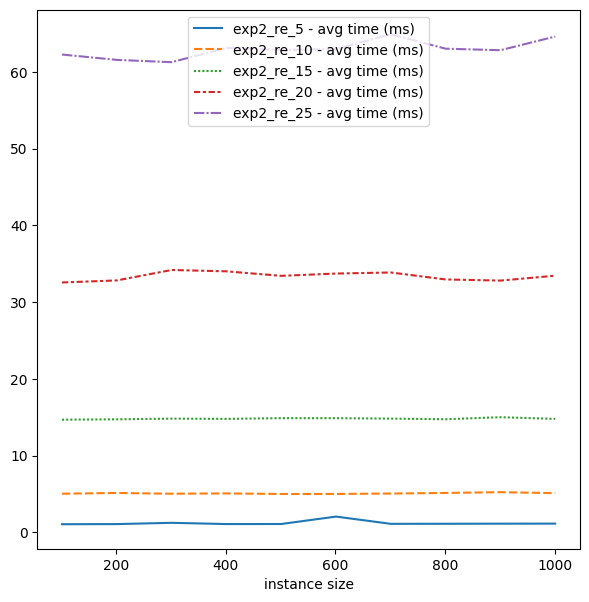

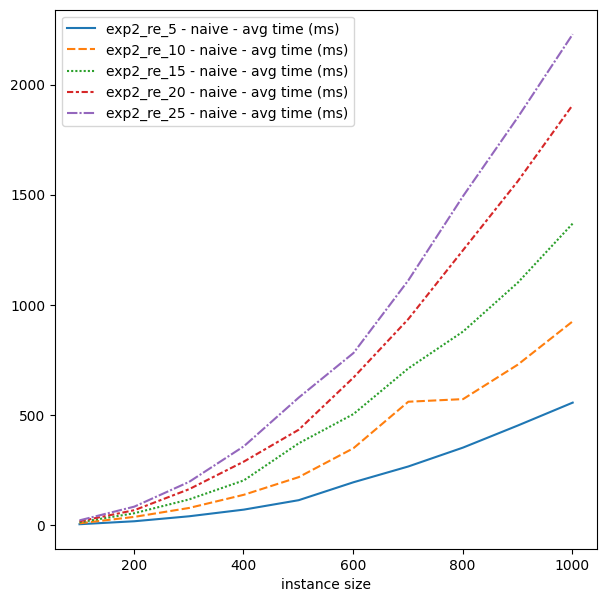

In [35]:
fig, axes = plt.subplots(1, 1, figsize=(7, 7))
sns.lineplot(data=exp2_times_df, ax=axes)
plt.savefig(f'{GRAPHICS_DIR}/exp2_times.png')


fig, axes = plt.subplots(1, 1, figsize=(7, 7))
sns.lineplot(data=exp2_naive_times_df, ax=axes)
plt.savefig(f'{GRAPHICS_DIR}/exp2_naive_times.png')